In [3]:
import numpy as np
import random
from collections import defaultdict, deque
import math
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict

class GridWorld:
    def __init__(self, size=10, n_obstacles=15):
        self.size = size
        self.grid = np.zeros((size, size))
        self.start = (0, 0)
        self.goal = (size-1, size-1)
        obstacles = set()
        while len(obstacles) < n_obstacles:
            obs = (random.randint(0, size-1), random.randint(0, size-1))
            if obs not in [self.start, self.goal]:
                obstacles.add(obs)
                self.grid[obs] = 1
        self.reset()
    def reset(self):
        self.agent_pos = self.start
        return self.agent_pos
    def step(self, action):
        moves = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        new_pos = (self.agent_pos[0] + moves[action][0],
                   self.agent_pos[1] + moves[action][1])
        if (0 <= new_pos[0] < self.size and 0 <= new_pos[1] < self.size
            and self.grid[new_pos] == 0):
            self.agent_pos = new_pos
        if self.agent_pos == self.goal:
            reward, done = 100, True
        else:
            reward, done = -1, False
        return self.agent_pos, reward, done
    def get_valid_actions(self, state):
        moves = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        valid = []
        for i, move in enumerate(moves):
            new_pos = (state[0] + move[0], state[1] + move[1])
            if (0 <= new_pos[0] < self.size and 0 <= new_pos[1] < self.size
                and self.grid[new_pos] == 0):
                valid.append(i)
        return valid

In [4]:
class QLearningAgent:
    def __init__(self, n_actions=4, alpha=0.1, gamma=0.95, epsilon=1.0):
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = defaultdict(lambda: np.zeros(n_actions))
    def get_action(self, state, valid_actions):
        if random.random() < self.epsilon:
            return random.choice(valid_actions)
        else:
            q_values = self.q_table[state]
            valid_q = [(a, q_values[a]) for a in valid_actions]
            return max(valid_q, key=lambda x: x[1])[0]
    def update(self, state, action, reward, next_state, valid_next_actions):
        current_q = self.q_table[state][action]
        if valid_next_actions:
            max_next_q = max([self.q_table[next_state][a] for a in valid_next_actions])
        else:
            max_next_q = 0
        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
        self.q_table[state][action] = new_q
    def decay_epsilon(self, decay_rate=0.995):
        self.epsilon = max(0.01, self.epsilon * decay_rate)

In [5]:
class UCBAgent:
    def __init__(self, n_actions=4, c=2.0, gamma=0.95):
        self.n_actions = n_actions
        self.c = c
        self.gamma = gamma
        self.q_values = defaultdict(lambda: np.zeros(n_actions))
        self.action_counts = defaultdict(lambda: np.zeros(n_actions))
        self.total_counts = defaultdict(int)
    def get_action(self, state, valid_actions):
        self.total_counts[state] += 1
        ucb_values = []
        for action in valid_actions:
            q = self.q_values[state][action]
            count = self.action_counts[state][action]
            if count == 0:
                return action
            exploration_bonus = self.c * math.sqrt(math.log(self.total_counts[state]) / count)
            ucb_values.append((action, q + exploration_bonus))
        return max(ucb_values, key=lambda x: x[1])[0]
    def update(self, state, action, reward, next_state, valid_next_actions):
        self.action_counts[state][action] += 1
        count = self.action_counts[state][action]
        current_q = self.q_values[state][action]
        if valid_next_actions:
            max_next_q = max([self.q_values[next_state][a] for a in valid_next_actions])
        else:
            max_next_q = 0
        target = reward + self.gamma * max_next_q
        self.q_values[state][action] += (target - current_q) / count

In [6]:
class MCTSNode:
    def __init__(self, state, parent=None):
        self.state = state
        self.parent = parent
        self.children = {}
        self.visits = 0
        self.value = 0.0
    def is_fully_expanded(self, valid_actions):
        return len(self.children) == len(valid_actions)
    def best_child(self, c=1.4):
        choices = [(action, child.value / child.visits +
                    c * math.sqrt(2 * math.log(self.visits) / child.visits))
                   for action, child in self.children.items()]
        return max(choices, key=lambda x: x[1])

class MCTSAgent:
    def __init__(self, env, n_simulations=50):
        self.env = env
        self.n_simulations = n_simulations
    def search(self, state):
        root = MCTSNode(state)
        for _ in range(self.n_simulations):
            node = root
            sim_env = GridWorld(size=self.env.size)
            sim_env.grid = self.env.grid.copy()
            sim_env.agent_pos = state
            while node.is_fully_expanded(sim_env.get_valid_actions(node.state)) and node.children:
                action, _ = node.best_child()
                node = node.children[action]
                sim_env.agent_pos = node.state
            valid_actions = sim_env.get_valid_actions(node.state)
            if valid_actions and not node.is_fully_expanded(valid_actions):
                untried = [a for a in valid_actions if a not in node.children]
                action = random.choice(untried)
                next_state, _, _ = sim_env.step(action)
                child = MCTSNode(next_state, parent=node)
                node.children[action] = child
                node = child
            total_reward = 0
            depth = 0
            while depth < 20:
                valid = sim_env.get_valid_actions(sim_env.agent_pos)
                if not valid:
                    break
                action = random.choice(valid)
                _, reward, done = sim_env.step(action)
                total_reward += reward
                depth += 1
                if done:
                    break
            while node:
                node.visits += 1
                node.value += total_reward
                node = node.parent
        if root.children:
            return max(root.children.items(), key=lambda x: x[1].visits)[0]
        return random.choice(self.env.get_valid_actions(state))

Problem Solving via Exploration Agents Tutorial

Training Q-Learning (ε-greedy)...
Episode 100/300, Avg Reward: 4.10
Episode 200/300, Avg Reward: 73.78
Episode 300/300, Avg Reward: 81.06

Training UCB Agent...
Episode 100/300, Avg Reward: 70.20
Episode 200/300, Avg Reward: 85.66
Episode 300/300, Avg Reward: 86.42

Training MCTS Agent...
Episode 100/300, Avg Reward: -100.00
Episode 200/300, Avg Reward: -100.00
Episode 300/300, Avg Reward: -100.00


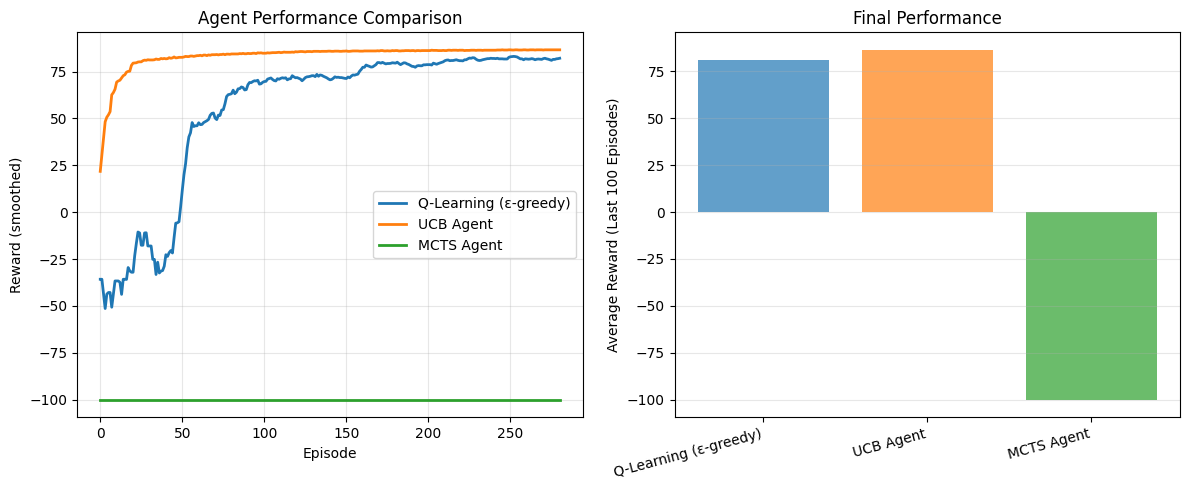

Tutorial Complete!
Key Concepts Demonstrated:
1. Epsilon-Greedy exploration
2. UCB strategy
3. MCTS-based planning


In [7]:
def train_agent(agent, env, episodes=500, max_steps=100, agent_type="standard"):
    rewards_history = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        for step in range(max_steps):
            valid_actions = env.get_valid_actions(state)
            if agent_type == "mcts":
                action = agent.search(state)
            else:
                action = agent.get_action(state, valid_actions)
            next_state, reward, done = env.step(action)
            total_reward += reward
            if agent_type != "mcts":
                valid_next = env.get_valid_actions(next_state)
                agent.update(state, action, reward, next_state, valid_next)
            state = next_state
            if done:
                break
        rewards_history.append(total_reward)
        if hasattr(agent, 'decay_epsilon'):
            agent.decay_epsilon()
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(rewards_history[-100:])
            print(f"Episode {episode+1}/{episodes}, Avg Reward: {avg_reward:.2f}")
    return rewards_history

if __name__ == "__main__":
    print("=" * 70)
    print("Problem Solving via Exploration Agents Tutorial")
    print("=" * 70)
    env = GridWorld(size=8, n_obstacles=10)
    agents_config = {
        'Q-Learning (ε-greedy)': (QLearningAgent(), 'standard'),
        'UCB Agent': (UCBAgent(), 'standard'),
        'MCTS Agent': (MCTSAgent(env, n_simulations=30), 'mcts')
    }
    results = {}
    for name, (agent, agent_type) in agents_config.items():
        print(f"\nTraining {name}...")
        rewards = train_agent(agent, GridWorld(size=8, n_obstacles=10),
                              episodes=300, agent_type=agent_type)
        results[name] = rewards
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for name, rewards in results.items():
        smoothed = np.convolve(rewards, np.ones(20)/20, mode='valid')
        plt.plot(smoothed, label=name, linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('Reward (smoothed)')
    plt.title('Agent Performance Comparison')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.subplot(1, 2, 2)
    for name, rewards in results.items():
        avg_last_100 = np.mean(rewards[-100:])
        plt.bar(name, avg_last_100, alpha=0.7)
    plt.ylabel('Average Reward (Last 100 Episodes)')
    plt.title('Final Performance')
    plt.xticks(rotation=15, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    print("=" * 70)
    print("Tutorial Complete!")
    print("Key Concepts Demonstrated:")
    print("1. Epsilon-Greedy exploration")
    print("2. UCB strategy")
    print("3. MCTS-based planning")
    print("=" * 70)